# Testing a Difference in Slopes

Here's a [question from the Reddit statistics forum](https://www.reddit.com/r/statistics/comments/1cxxsyb/comment/l56k35f/?context=3).

> How do I determine if the difference in change-speed is significant?
> 
> Hi! I'm doing a project for uni and I'm in need of a statistical test but I'm not well read enough on statistics to figure out which.
>
> I have 7 years worth of anual data (average plant diversity, using Shannon Wiener) from two separate locations and I need to figure out if there is a significant difference between the two locations in the speed at which the diversity changes.
>
> Let me know if any additional information is needed to figure this out!

We can do this by resampling, but we'll need to think about how to model the data-generating process and the null hypothesis.
One of the best ways to model the data-generating process is to generate some random data.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataQnA/blob/main/nb/diff_actual.ipynb).

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataQnA/raw/main/nb/utils.py')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate

In [2]:
# install the empiricaldist library, if necessary

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

## Answer

I'll start with a range of 7 years.

In [3]:
n = 7
xs = np.arange(n)

And generate fake datasets with different intercepts and slopes, but the same standard deviation of the error terms, `sigma`.

In [4]:
np.random.seed(1)

sigma = 1
ys1 = 10 - 1 * xs + np.random.normal(0, sigma, size=n)
ys2 = 8 - 1.5 * xs + np.random.normal(0, sigma, size=n)

Here's what the data look like.

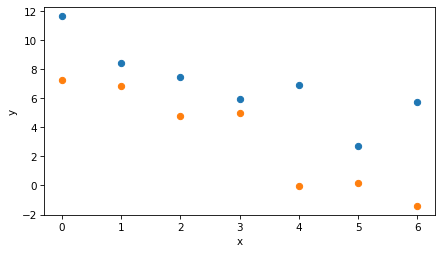

In [5]:
plt.plot(xs, ys1, 'o')
plt.plot(xs, ys2, 'o')

decorate(xlabel='x', ylabel='y')

And here are the estimated slopes for the two datasets separately.

In [6]:
from scipy.stats import linregress

res1 = linregress(xs, ys1)
res1.slope

-1.0580209279718773

In [7]:
res2 = linregress(xs, ys2)
res2.slope

-1.5700794748386209

Here's the observed difference in the slopes.

In [8]:
diff_actual = res1.slope - res2.slope
diff_actual

0.5120585468667436

## The null hypothesis

Now, if the question is whether this difference might be due to chance, we have to define what we mean by "due to chance".
In this example, the null hypothesis is that the slope is the same, so the first question we have to answer is, "If the slope is the same, what is it?"

To answer that, we can use multiple regression with both datasets, constrained so they have the same slope, but allowing them to have different intercepts.
First I'll combine the datasets in a single `DataFrame`, with a column indicating which group each row is from.

In [9]:
df1 = pd.DataFrame(dict(x=xs, y=ys1))
df1['group'] = 1
df1

,x,y,group
0,0,11.624345,1
1,1,8.388244,1
2,2,7.471828,1
3,3,5.927031,1
4,4,6.865408,1
5,5,2.698461,1
6,6,5.744812,1


In [10]:
df2 = pd.DataFrame(dict(x=xs, y=ys2))
df2['group'] = 2
df2

,x,y,group
0,0,7.238793,2
1,1,6.819039,2
2,2,4.750630,2
3,3,4.962108,2
4,4,-0.060141,2
5,5,0.177583,2
6,6,-1.384054,2


In [11]:
df = pd.concat([df1, df2]).reset_index(drop=True)
df

,x,y,group
0,0,11.624345,1
1,1,8.388244,1
2,2,7.471828,1
3,3,5.927031,1
4,4,6.865408,1
5,5,2.698461,1
6,6,5.744812,1
7,0,7.238793,2
8,1,6.819039,2
9,2,4.750630,2


Now we can run the regression.

In [22]:
import warnings

warnings.filterwarnings('ignore', message='kurtosistest*')

In [23]:
import statsmodels.formula.api as smf

formula = 'y ~ x + C(group)'
result = smf.ols(formula, data=df).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     33.73
Date:                Wed, 22 May 2024   Prob (F-statistic):           2.03e-05
Time:                        14:54:11   Log-Likelihood:                -23.570
No. Observations:                  14   AIC:                             53.14
Df Residuals:                      11   BIC:                             55.06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        10.9022      0.810     13.461      0.000       9.120      12.685
C(group)[T.2]    -3.7452      0.786     -4.766      0.001      -5.475      -2.016
x                -1.3141      0.196     -6.690      0.000      -1.746      -0.882
==============================================================================
Omnibus:                        0.732   Durbin-Watson:                   2.652
Prob(Omnibus):                  0.694   Jarque-Bera (JB):                0.688
Skew:                           0.425   Prob(JB):                        0.709
Kurtosis:                       2.323   Cond. No.                         9.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Under the assumption that the slope is the same in both groups, the estimated slope is about -1.2, and the intercepts for the groups are different.

We can use `predict` to generate fitted values for each group.

In [13]:
fit1 = result.predict(df1)
fit2 = result.predict(df2)

And here's what they look like compared to the data.

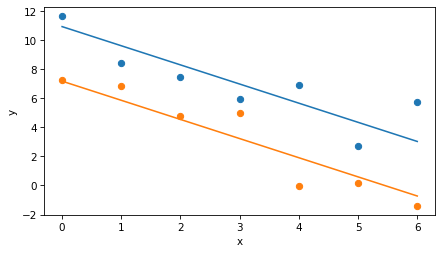

In [14]:
plt.plot(xs, ys1, 'o')
plt.plot(xs, fit1, color='C0')
plt.plot(xs, ys2, 'o')
plt.plot(xs, fit2, color='C1')

decorate(xlabel='x', ylabel='y')

## Simulating the null hypothesis

To compute a p-value, we have to compute the test statistic -- the difference in slopes -- for datasets generated under the null hypothesis.
We can do that by choosing random residuals and adding them to the fitted lines.

Here's what the residuals look like.

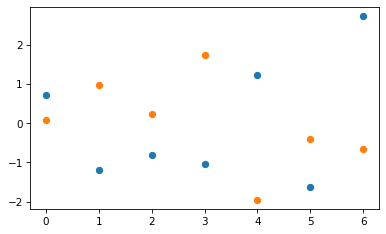

In [15]:
resid1 = ys1 - fit1
resid2 = ys2 - fit2

plt.plot(xs, resid1, 'o')
plt.plot(xs, resid2, 'o')

In [16]:
resid = np.concatenate([resid1, resid2])

The following function generates random datasets under the null hypothesis and computes the difference in their slopes.

In [17]:
def resample_slope():
    resampled1 = fit1 + np.random.choice(resid, size=n, replace=True)
    resampled2 = fit2 + np.random.choice(resid, size=n, replace=True)

    res1 = linregress(xs, resampled1)
    res2 = linregress(xs, resampled2)
    diff = res2.slope - res1.slope
    return diff

If we call this function once, we get a single instance of the test statistic under the null hypothesis -- this is the answer to the question, "If there were actually no difference in the slopes and we ran the experiment again, how big a difference might we see by chance?"

In [18]:
resample_slope()

-0.11589135335692213

If we run it many times, we get a sample of the test statistic under the null hypothesis.

In [19]:
diffs = [resample_slope() for i in range(1001)]

Here's what the distribution of the test statistic looks like.

<Axes: ylabel='Density'>

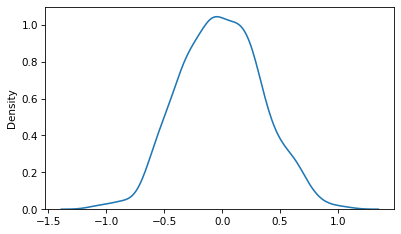

In [20]:
sns.kdeplot(diffs)

The mean is near 0, as we expect if there were actually no difference in the slopes.
But the tails extend past the observed difference, which is near 0.5.
That means that a difference as big as 0.5 could plausibly happen by chance.

To quantify how plausible, we can compute the p-value, which is the fraction of the sample that exceeds the observed difference in magnitude.

In [21]:
p_value = np.mean(np.abs(diffs) >= np.abs(diff_actual))
p_value

0.14485514485514486

For the fake dataset I generated, the p-value is about 14%, which means that the observed difference could plausibly happen by chance, even if the slopes are actually the same in the two groups.

## The parametric version

In [24]:
m, s = np.mean(resid), np.std(resid)

In [27]:
def resample_slope2():
    resampled1 = fit1 + np.random.normal(m, s, size=n)
    resampled2 = fit2 + np.random.normal(m, s, size=n)

    res1 = linregress(xs, resampled1)
    res2 = linregress(xs, resampled2)
    diff = res2.slope - res1.slope
    return diff

In [28]:
resample_slope2()

0.30758321416824463

In [29]:
diffs2 = [resample_slope2() for i in range(1001)]

<Axes: ylabel='Density'>

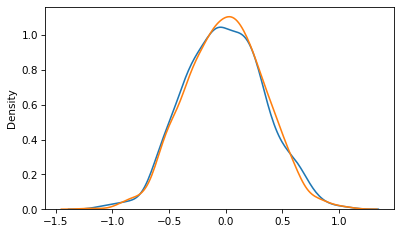

In [31]:
sns.kdeplot(diffs)
sns.kdeplot(diffs2)

In [32]:
p_value = np.mean(np.abs(diffs2) >= np.abs(diff_actual))
p_value

0.13286713286713286

## Discussion

[*Data Q&A: Answering the real questions with Python*](https://allendowney.github.io/DataQnA/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)